# Gerekli Kütüphaneleri Yüklenmesi

In [2]:
from sklearn.datasets import load_iris  # Iris veri setini yüklemek için  
from sklearn.model_selection import train_test_split  # Eğitim/test verisini ayırmak için  
from sklearn.preprocessing import StandardScaler, LabelBinarizer  # Verileri ölçeklemek ve etiketleri dönüştürmek için  

from tensorflow.keras.models import Sequential  # Katmanlı model oluşturmak için  
from tensorflow.keras.layers import Layer, Dense, Flatten  # Yapay sinir ağı katmanları için  
from tensorflow.keras import backend as K  # Keras backend işlemleri için  

import matplotlib.pyplot as plt  # Grafik çizimleri için  

import warnings; warnings.filterwarnings("ignore")  # Uyarı mesajlarını gizlemek için

# 📊 Veri Yükleme ve Ön İşleme

In [3]:
iris = load_iris()  # Iris veri setini yüklüyoruz

X = iris.data  # Özellikleri (sepal/petal uzunluk-genişlik) alıyoruz
y = iris.target  # Sınıf etiketlerini (0,1,2) alıyoruz

label_binarizer = LabelBinarizer()  # Etiketleri one-hot encode etmek için nesne oluşturduk
y = label_binarizer.fit_transform(y)  # Etiketleri dönüştürdük

scaler = StandardScaler()  # Özellikleri ölçeklendirmek için StandardScaler nesnesi oluşturduk
X_scaled = scaler.fit_transform(X)  # X verisini normalize ettik

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=32)  # Veriyi %80 eğitim, %20 test olarak ayırdık

# 🧠 Özel RBF Katmanı Tanımı (Keras Custom Layer)

In [4]:
class RBFLayer(Layer):  # Keras'tan türetilmiş özel bir katman sınıfı tanımlıyoruz
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units  # RBF katmanındaki gizli nöron sayısı
        self.gamma = K.cast_to_floatx(gamma)  # RBF fonksiyonunun yayılım parametresi (duyarlılık)

    def build(self, input_shape):
        """
        Katmanın ağırlıkları burada tanımlanır.
        Keras, bu metodu katman ilk defa veri aldığında otomatik çağırır.
        """
        self.mu = self.add_weight(
            name="mu",  # Ağırlık ismi
            shape=(int(input_shape[1]), self.units),  # Ağırlık matrisinin boyutu (özellik_sayısı, nöron_sayısı)
            initializer="uniform",  # Başlangıç ağırlıklarını uniform dağılımla belirliyoruz
            trainable=True  # Bu ağırlıklar eğitilebilir olacak
        )
        super(RBFLayer, self).build(input_shape)  # build işlemini üst sınıfa bildir

    def call(self, inputs):
        """
        Katman çağırıldığında çalışacak kısım. Girdiden çıktıyı üretir.
        """
        diff = K.expand_dims(inputs) - self.mu  # Girdiler ile merkezler arasındaki fark
        l2 = K.sum(K.pow(diff, 2), axis=1)  # L2 normunun karesi (Euclidean mesafe)
        res = K.exp(-1 * self.gamma * l2)  # RBF çıkışı: exp(-gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        """
        Katmanın çıktısının şekli tanımlanır.
        """
        return (input_shape[0], self.units)  # (örnek_sayısı, nöron_sayısı)

# 🏗️ Modeli Oluşturma Fonksiyonu


In [5]:
def build_model():
    model = Sequential()  # Sıralı (katman katman) bir model tanımlıyoruz

    model.add(Flatten(input_shape=(4,)))  # Giriş verisini düzleştiriyoruz (4 özellik → 1D vektör)

    model.add(RBFLayer(10, 0.5))  # Özel RBF katmanını ekliyoruz: 10 nöron, gamma = 0.5

    model.add(Dense(3, activation="softmax"))  # Çıkış katmanı: 3 sınıf için softmax aktivasyonu

    model.compile(
        loss="categorical_crossentropy",  # Çok sınıflı sınıflandırma kaybı
        optimizer="adam",  # Adam optimizasyon algoritması
        metrics=["accuracy"]  # Başarı metriği olarak doğruluk
    )

    return model  # Modeli döndürüyoruz

# 🚆 Modeli Eğitme ve Değerlendirme

In [6]:
# Modeli oluşturuyoruz
model = build_model()

# Modeli eğitiyoruz
history = model.fit(
    X_train, y_train,                # Eğitim verisi
    epochs=100,                      # Eğitim döngüsü sayısı
    batch_size=4,                    # Her adımda kaç örnek kullanılacağı
    validation_split=0.3,            # Eğitim verisinin %30'u doğrulama için ayrılır
    verbose=1                        # Eğitim süreci ayrıntılı gösterilsin
)

# Modeli test verisi üzerinde değerlendiriyoruz
loss, accuracy = model.evaluate(X_test, y_test)  # Test veri setindeki kayıp ve doğruluk hesaplanır

print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.2f}")  # Sonuçları yazdırıyoruz

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3102 - loss: 1.3821 - val_accuracy: 0.2778 - val_loss: 1.4283
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3494 - loss: 1.4883 - val_accuracy: 0.2778 - val_loss: 1.3595
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3563 - loss: 1.2946 - val_accuracy: 0.2778 - val_loss: 1.3019
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3691 - loss: 1.1876 - val_accuracy: 0.3611 - val_loss: 1.2526
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4631 - loss: 1.2087 - val_accuracy: 0.4722 - val_loss: 1.1996
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4203 - loss: 1.1882 - val_accuracy: 0.5000 - val_loss: 1.1534
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5340 - loss: 1.1225 - val_accuracy: 0.5278 - val_loss: 1.1125
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5530 - loss: 1.1054 - val_accuracy: 0.638

# 📈 Eğitim Sürecinin Görselleştirilmesi


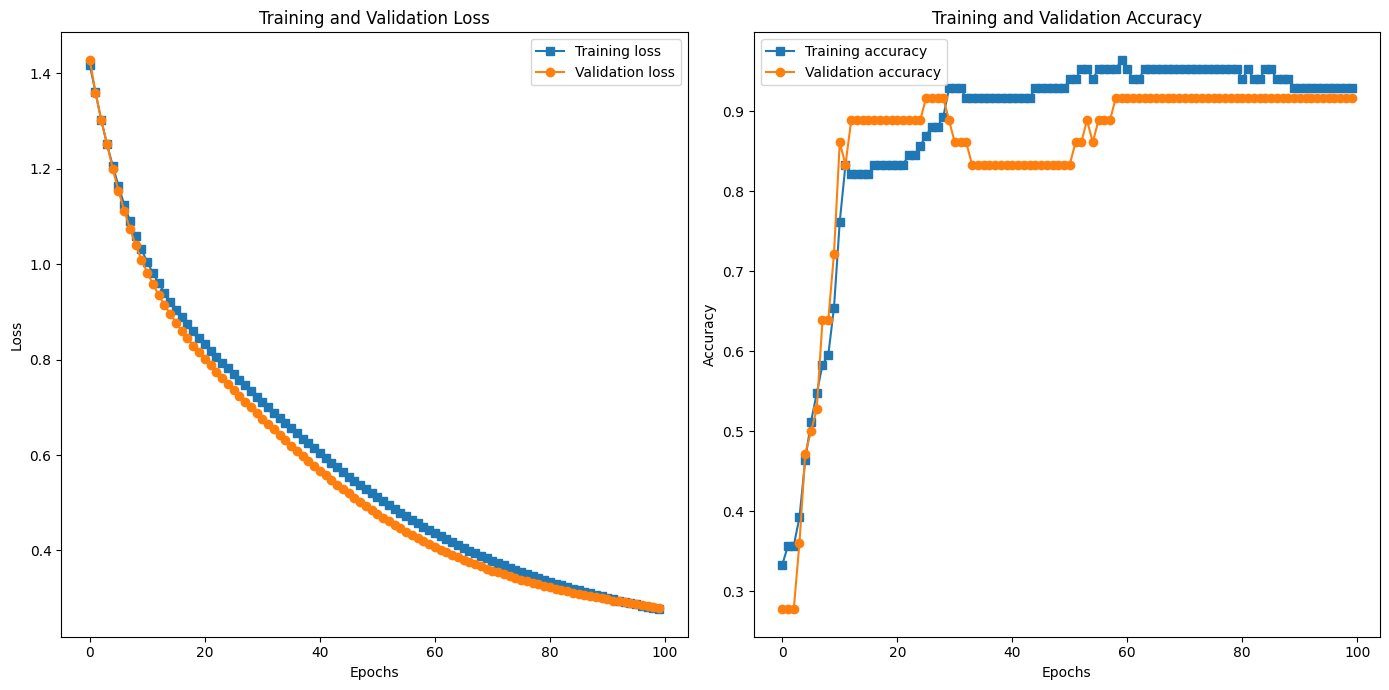

In [7]:
# Eğitim ve doğrulama süreçlerinin kayıp ve doğruluk grafiklerini çiziyoruz

fig, ax = plt.subplots(1, 2, figsize=(14, 7))  # 1 satır 2 grafik alanı oluşturduk

# Eğitim ve doğrulama kaybı
ax[0].plot(history.history["loss"], "s-", label="Training loss")
ax[0].plot(history.history["val_loss"], "o-", label="Validation loss")
ax[0].set_title("Training and Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Eğitim ve doğrulama doğruluğu
ax[1].plot(history.history["accuracy"], "s-", label="Training accuracy")
ax[1].plot(history.history["val_accuracy"], "o-", label="Validation accuracy")
ax[1].set_title("Training and Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()  # Grafiklerin birbirine girmemesi için sıkı yerleşim
plt.show()